# A/B тестирование

# Введение

**Название проекта:** A/B-тестирование

**Описание проекта:** Используя данные о маркетинговых компаниях, проводимых тестах, пользователях и логах исследовать a/b тест, связанный с внедрением улучшенной рекомендательной системой магазина, и проверить рабочую гипотезу.

**Цель:** Оценить корректность проведения теста согласно ТЗ и проанализировать его результаты.

**Задачи:**
- Исследовать данные:
    - Требуется ли преобразование типов?
    - Описать природу пропущенных значений и дубликатов, если они есть.
- Оценить корректность проведения теста
    - Соответствие данных требованиям технического задания.
    - Время проведения теста.
    - Аудитория теста. 
- Провести исследовательский анализ данных:
    - Количество событий на пользователя одинаково распределены в выборках?
    - Как число событий в выборках распределено по дням?
    - Как меняется конверсия в воронке в выборках на разных этапах?
    - Какие особенности данных нужно учесть, прежде чем приступать к A B-тестированию?
- Оценить результаты A/B-тестирования
    - Что можно сказать про результаты A/В-тестирования?
    - Проверьте статистическую разницу долей z-критерием.
- Опишите выводы по EDA и по A/B-тестированию. Сделать общее заключение о корректности проведения теста.

**Исходные данные:**
- ab_project_marketing_events.csv — календарь маркетинговых событий на 2020 год
- final_ab_new_users.csv — пользователи, зарегистрировавшиеся с 7 по 21 декабря 2020 года
- final_ab_events.csv — действия новых пользователей в период с 7 декабря 2020 по 4 января 2021 года
- final_ab_participants.csv — таблица участников тестов.

**Техническое задание**
- Название теста: `recommender_system_test`;
- группы: А — контрольная, B — новая платёжная воронка;
- дата запуска: 2020-12-07;
- дата остановки набора новых пользователей: 2020-12-21;
- дата остановки: 2021-01-04;
- аудитория: 15% новых пользователей из региона EU;
- назначение теста: тестирование изменений, связанных с внедрением улучшенной рекомендательной системы;
- ожидаемое количество участников теста: 6000.
- ожидаемый эффект: за 14 дней с момента регистрации пользователи покажут улучшение каждой метрики не менее, чем на 10%:
    - конверсии в просмотр карточек товаров — событие `product_page`,
    - просмотры корзины — `product_cart`,
    - покупки — `purchase`.

# Подключение библиотек

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats as st
import numpy as np
import math as mth
from plotly import graph_objects as go

# Загрузка и предобработка данных

In [2]:
# загрузка данных
try:
    try:
        ab_project_marketing_events = pd.read_csv(r"C:\Users\Gleb\Мой диск\ЯПрактикум\финальный проект\a b тесты\ab_project_marketing_events.csv")
    except:
        ab_project_marketing_events = pd.read_csv('/Users/glebderabin/Мой диск/ЯПрактикум/финальный проект/a b тесты/ab_project_marketing_events.csv')
except:
    ab_project_marketing_events = pd.read_csv('/datasets/ab_project_marketing_events.csv')

try:
    try:
        final_ab_events = pd.read_csv(r"C:\Users\Gleb\Мой диск\ЯПрактикум\финальный проект\a b тесты\final_ab_events.csv")
    except:
        final_ab_events = pd.read_csv('/Users/glebderabin/Мой диск/ЯПрактикум/финальный проект/a b тесты/final_ab_events.csv')
except:
    final_ab_events = pd.read_csv('/datasets/final_ab_events.csv')

try:
    try:
        final_ab_new_users = pd.read_csv(r"C:\Users\Gleb\Мой диск\ЯПрактикум\финальный проект\a b тесты\final_ab_new_users.csv")
    except:
        final_ab_new_users = pd.read_csv('/Users/glebderabin/Мой диск/ЯПрактикум/финальный проект/a b тесты/final_ab_new_users.csv')
except:
    final_ab_new_users = pd.read_csv('/datasets/final_ab_new_users.csv')

try:
    try:
        final_ab_participants = pd.read_csv(r"C:\Users\Gleb\Мой диск\ЯПрактикум\финальный проект\a b тесты\final_ab_participants.csv")
    except:
        final_ab_participants = pd.read_csv('/Users/glebderabin/Мой диск/ЯПрактикум/финальный проект/a b тесты/final_ab_participants.csv')
except:
    final_ab_participants = pd.read_csv('/datasets/final_ab_participants.csv')    

## Предобработка ab_project_marketing_events

Календарь маркетинговых событий на 2020 год.

Структура файла:
- `name` — название маркетингового события;
- `regions` — регионы, в которых будет проводиться рекламная кампания;
- `start_dt` — дата начала кампании;
- `finish_dt` — дата завершения кампании.

In [3]:
# изучаю основную информацию о наборе данных
display(ab_project_marketing_events.head())
display(ab_project_marketing_events.info())
display(ab_project_marketing_events.describe())
print('Количество пропусков в таблице: ', ab_project_marketing_events.isnull().sum().sum()) 
print('Количество полных дубликатов строк в таблице: ', ab_project_marketing_events.duplicated().sum())

,name,regions,start_dt,finish_dt
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03
1,St. Valentine's Day Giveaway,"EU, CIS, APAC, N.America",2020-02-14,2020-02-16
2,St. Patric's Day Promo,"EU, N.America",2020-03-17,2020-03-19
3,Easter Promo,"EU, CIS, APAC, N.America",2020-04-12,2020-04-19
4,4th of July Promo,N.America,2020-07-04,2020-07-11


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   name       14 non-null     object
 1   regions    14 non-null     object
 2   start_dt   14 non-null     object
 3   finish_dt  14 non-null     object
dtypes: object(4)
memory usage: 576.0+ bytes


None

,name,regions,start_dt,finish_dt
count,14,14,14,14
unique,14,6,14,14
top,Christmas&New Year Promo,APAC,2020-11-26,2020-07-01
freq,1,4,1,1


Количество пропусков в таблице:  0
Количество полных дубликатов строк в таблице:  0


В таблице нет пропусков и дубликатов. Нужно перевести поля start_dt и finish_dt к типу дататайм

In [4]:
# привожу поля к типу дататайм
ab_project_marketing_events['start_dt'] = pd.to_datetime(ab_project_marketing_events['start_dt'])
ab_project_marketing_events['finish_dt'] = pd.to_datetime(ab_project_marketing_events['finish_dt'])

## Предобработка final_ab_events

Действия новых пользователей в период с 7 декабря 2020 по 4 января 2021 года.

Структура файла:

- `user_id` — идентификатор пользователя;
- `event_dt` — дата и время события;
- `event_name` — тип события;
- `details` — дополнительные данные о событии. Например, для покупок, `purchase,` в этом поле хранится стоимость покупки в долларах.

In [5]:
# изучаю основную информацию о наборе данных
display(final_ab_events.head())
display(final_ab_events.info())
display(final_ab_events.describe())
print('Количество пропусков в таблице: ', final_ab_events.isnull().sum().sum()) 
print('Количество полных дубликатов строк в таблице: ', final_ab_events.duplicated().sum())

,user_id,event_dt,event_name,details
0,E1BDDCE0DAFA2679,2020-12-07 20:22:03,purchase,99.99
1,7B6452F081F49504,2020-12-07 09:22:53,purchase,9.99
2,9CD9F34546DF254C,2020-12-07 12:59:29,purchase,4.99
3,96F27A054B191457,2020-12-07 04:02:40,purchase,4.99
4,1FD7660FDF94CA1F,2020-12-07 10:15:09,purchase,4.99


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440317 entries, 0 to 440316
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   user_id     440317 non-null  object 
 1   event_dt    440317 non-null  object 
 2   event_name  440317 non-null  object 
 3   details     62740 non-null   float64
dtypes: float64(1), object(3)
memory usage: 13.4+ MB


None

,details
count,62740.000000
mean,23.877631
std,72.180465
min,4.990000
25%,4.990000
50%,4.990000
75%,9.990000
max,499.990000


Количество пропусков в таблице:  377577
Количество полных дубликатов строк в таблице:  0


В датасете нет дубликатов. Есть пропуски в поле details, скорее всего это связано с механикой сбора данных (записывается только сумма для события purchase). Это нужно проверить и привести поле event_dt к типу дататайм

In [6]:
# Кол-во строк, в которых должны быть пропуски согласно механике сбора данных
print('Кол-во событий исключая purchase', len(final_ab_events.query('event_name != "purchase"')))

# привожу поле к типу дататайм
final_ab_events['event_dt'] = pd.to_datetime(final_ab_events['event_dt'])

Кол-во событий исключая purchase 377577


Все верно, пропуски связаны с механикой сбора данных и это нормально. Для всех покупок есть сумма сделки.

## Предобработка final_ab_new_users

Пользователи, зарегистрировавшиеся с 7 по 21 декабря 2020 года.

Структура файла:

- `user_id` — идентификатор пользователя;
- `first_date` — дата регистрации;
- `region` — регион пользователя;
- `device` — устройство, с которого происходила регистрация.

In [7]:
# изучаю основную информацию о наборе данных
display(final_ab_new_users.head())
display(final_ab_new_users.info())
display(final_ab_new_users.describe())
print('Количество пропусков в таблице: ', final_ab_new_users.isnull().sum().sum()) 
print('Количество полных дубликатов строк в таблице: ', final_ab_new_users.duplicated().sum())

,user_id,first_date,region,device
0,D72A72121175D8BE,2020-12-07,EU,PC
1,F1C668619DFE6E65,2020-12-07,N.America,Android
2,2E1BF1D4C37EA01F,2020-12-07,EU,PC
3,50734A22C0C63768,2020-12-07,EU,iPhone
4,E1BDDCE0DAFA2679,2020-12-07,N.America,iPhone


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61733 entries, 0 to 61732
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     61733 non-null  object
 1   first_date  61733 non-null  object
 2   region      61733 non-null  object
 3   device      61733 non-null  object
dtypes: object(4)
memory usage: 1.9+ MB


None

,user_id,first_date,region,device
count,61733,61733,61733,61733
unique,61733,17,4,4
top,CB766C67709D15CB,2020-12-21,EU,Android
freq,1,6290,46270,27520


Количество пропусков в таблице:  0
Количество полных дубликатов строк в таблице:  0


В таблице нет дубликатов и пропусков, нужно привести поле first_date к типу дататайм.

In [8]:
# привожу поле к типу дататайм
final_ab_new_users['first_date'] = pd.to_datetime(final_ab_new_users['first_date'])

## Предобработка final_ab_participants

таблица участников тестов.

Структура файла:

- `user_id` — идентификатор пользователя;
- `ab_test` — название теста;
- `group` — группа пользователя.

In [9]:
# изучаю основную информацию о наборе данных
display(final_ab_participants.head())
display(final_ab_participants.info())
display(final_ab_participants.describe())
print('Количество пропусков в таблице: ', final_ab_participants.isnull().sum().sum()) 
print('Количество полных дубликатов строк в таблице: ', final_ab_participants.duplicated().sum())

,user_id,group,ab_test
0,D1ABA3E2887B6A73,A,recommender_system_test
1,A7A3664BD6242119,A,recommender_system_test
2,DABC14FDDFADD29E,A,recommender_system_test
3,04988C5DF189632E,A,recommender_system_test
4,482F14783456D21B,B,recommender_system_test


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18268 entries, 0 to 18267
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  18268 non-null  object
 1   group    18268 non-null  object
 2   ab_test  18268 non-null  object
dtypes: object(3)
memory usage: 428.3+ KB


None

,user_id,group,ab_test
count,18268,18268,18268
unique,16666,2,2
top,41C7928F2ED27E66,A,interface_eu_test
freq,2,9655,11567


Количество пропусков в таблице:  0
Количество полных дубликатов строк в таблице:  0


В таблице нет дубликатов и пропусков, все поля имеют верный тип данных. Один или часть user_id встречается дважды, это будет проверено на этапе проверки соответствия данных ТЗ.

# Оценка корректности проведения теста

## Соответствие данных требованиям технического задания

Проверьте корректность всех пунктов технического задания.

In [10]:
# создаю срез участников по названию теста
recommender_system_test_participants = final_ab_participants.query('ab_test == "recommender_system_test"')

# Сроки приема новых пользователей
print('Ранняя регистрация пользователя:', final_ab_new_users['first_date'].min())
print('Поздняя регистрация пользователя:', final_ab_new_users['first_date'].max())

# Сроки логирования подтестовых событий
print('Раннее действие:', final_ab_events['event_dt'].min())
print('Позднее действие:', final_ab_events['event_dt'].max())

Ранняя регистрация пользователя: 2020-12-07 00:00:00
Поздняя регистрация пользователя: 2020-12-23 00:00:00
Раннее действие: 2020-12-07 00:00:33
Позднее действие: 2020-12-30 23:36:33


In [11]:
temp_3 = final_ab_new_users.merge(
                    right=final_ab_participants.query('ab_test == "recommender_system_test"'),
                    how='right',
                    on='user_id'
)
temp_3

# Сроки приема новых пользователей
print('Ранняя регистрация пользователя:', temp_3['first_date'].min())
print('Поздняя регистрация пользователя:', temp_3['first_date'].max())

Ранняя регистрация пользователя: 2020-12-07 00:00:00
Поздняя регистрация пользователя: 2020-12-21 00:00:00


Начало приема пользователей и останов приема пользователей соответствует ТЗ.

Дата запуска набора пользователей и логирования событий соответствует ТЗ. Логирование событий остановилось до предполагаемой даты так, что пользователям, привлеченным в последний день недели, не хватило времени до 14 дней. Нужно проверить распределение действий пользователей, и если они активны на протяжении всех 14 дней, то придеться убрать пользователей с 16 января.

In [12]:
# создаю срез пользователей по нужной дате и участию в нужном тесте
recommender_system_test_users = final_ab_new_users.query('first_date < "2020-12-22 00:00:00" and user_id in @recommender_system_test_participants["user_id"]')

# Проверяю количество участников теста
n_participants = len(recommender_system_test_users)
eu_share = len(recommender_system_test_users.query('region == "EU"'))/len(final_ab_new_users.query('first_date < "2020-12-22 00:00:00" and region == "EU"'))*100
print(f'Количество участников теста {n_participants} пользователей')
print(f'Процент пользователей из EU {eu_share} %')



Количество участников теста 6701 пользователей
Процент пользователей из EU 15.0 %


Требования ТЗ соблюдены

## Время проведения теста

Убедитесь, что оно не совпадает с маркетинговыми и другими активностями.

In [13]:
start_date = final_ab_events['event_dt'].min()
finish_date = final_ab_events['event_dt'].max()

for i in range(len(ab_project_marketing_events)):
    if (
        (ab_project_marketing_events.at[i, 'finish_dt'] > start_date and ab_project_marketing_events.at[i, 'finish_dt'] < finish_date) or
        (ab_project_marketing_events.at[i, 'start_dt'] > start_date and ab_project_marketing_events.at[i, 'start_dt'] < finish_date) or
        (ab_project_marketing_events.at[i, 'start_dt'] > start_date and ab_project_marketing_events.at[i, 'finish_dt'] < finish_date)):
        print(ab_project_marketing_events.at[i, 'name'])

Christmas&New Year Promo
CIS New Year Gift Lottery


Время проведения теста совпадает с маркетинговыми активностями Christmas&New Year Promo и CIS New Year Gift Lottery. С одной стороны, они могут повлиять на результаты теста, с другой - они повлияют на обе группы теста и вряд ли значительно изменят величины исследуемых метрик между группами

## Аудитория теста

### Удостоверьтесь, что нет пересечений с конкурирующим тестом

In [14]:
# среди участников теста не должно быть пользователей, которые есть в группах B других тестов
users_id_another_tests = final_ab_participants.query('ab_test != "recommender_system_test" and group == "B"')['user_id'].to_list()
wrong_users = []
for i in recommender_system_test_users['user_id']:
    if i in users_id_another_tests:
        wrong_users.append(i)

len(wrong_users)

783

Среди участников теста обнаружилось 783 пользователя, которые участвовали в группах B других тестов, то есть на них оказывали влияние другие эксперименты. Их нужно исключить

In [15]:
# исключаю пользователей, которые встречаются в группах B других экспериментов
recommender_system_test_participants = recommender_system_test_participants[~recommender_system_test_participants['user_id'].isin(wrong_users)]
recommender_system_test_users = recommender_system_test_users[~recommender_system_test_users['user_id'].isin(wrong_users)]

### Удостоверьтесь, что нет пользователей, участвующих в двух группах теста одновременно.

In [16]:
# в группе B не должно быть участников из группы А
users_a = recommender_system_test_participants.query('group == "A"')['user_id'].to_list()
users_b = recommender_system_test_participants.query('group == "B"')['user_id'].to_list()
users_test = recommender_system_test_participants['user_id'].to_list()
a_b_wrong_users = []
for i in users_b:
    if i in users_a:
        a_b_wrong_users.append(i)

len(a_b_wrong_users)

0

Пользователи из одного теста распределены по группам корректно

## Проверка пользователей по активности

In [17]:
# Список пользователей с действиями
users_w_activity = final_ab_events['user_id'].unique().tolist()

# исключаю из таблиц пользователей в случае отсутствия в списке
recommender_system_test_participants = recommender_system_test_participants[recommender_system_test_participants['user_id'].isin(users_w_activity)]
recommender_system_test_users = recommender_system_test_users[recommender_system_test_users['user_id'].isin(users_w_activity)]
users_test = recommender_system_test_participants['user_id'].to_list()

print(len(recommender_system_test_participants))
print(len(recommender_system_test_users))

3244
3244


In [18]:
# в логах оставлю отобранных пользователей
final_ab_events = final_ab_events[final_ab_events['user_id'].isin(users_test)]

В тесте после чисток осталось 3244 пользователя

Проверка равномерности распределения и правильности формирования групп

Проверять равномерность буду по количеству событий между днями привлечения и группой a/b

In [19]:
# По пользователям присоединю дату привлечения и подгруппу теста
final_ab_events = final_ab_events.merge(
                                        recommender_system_test_users[['user_id', 'first_date']],
                                        how='left',
                                        on='user_id'
)

# по пользователям из другой таблицы присоединю подгруппу
final_ab_events = final_ab_events.merge(
                                        recommender_system_test_participants[['user_id', 'group']],
                                        how='left',
                                        on='user_id'
)

По ТЗ лайфтайм должен быть 14 дней. Считаю разницу между событием и регистрацией пользователя, перевожу в дни и исключаю строки по условию > 14

In [20]:

final_ab_events['lifetime'] = final_ab_events['event_dt'] - final_ab_events['first_date']
final_ab_events['lifetime'] = final_ab_events['lifetime'].dt.days
final_ab_events = final_ab_events.query('lifetime <= 14')
final_ab_events

,user_id,event_dt,event_name,details,first_date,group,lifetime
0,831887FE7F2D6CBA,2020-12-07 06:50:29,purchase,4.99,2020-12-07,A,0
1,3C5DD0288AC4FE23,2020-12-07 19:42:40,purchase,4.99,2020-12-07,A,0
2,49EA242586C87836,2020-12-07 06:31:24,purchase,99.99,2020-12-07,B,0
3,2B06EB547B7AAD08,2020-12-07 21:36:38,purchase,4.99,2020-12-07,A,0
4,A640F31CAC7823A6,2020-12-07 18:48:26,purchase,4.99,2020-12-07,B,0
...,...,...,...,...,...,...,...
21835,930EACAE048DFF45,2020-12-29 06:56:00,login,NaN,2020-12-20,A,9
21836,36EDA624DB7B7F90,2020-12-29 20:54:25,login,NaN,2020-12-20,A,9
21837,E5589EAE02ACD150,2020-12-29 22:17:08,login,NaN,2020-12-20,A,9
21838,D21F0D4FDCD82DB2,2020-12-29 02:17:00,login,NaN,2020-12-20,A,9


Text(0, 0.5, 'Кол-во действий на пользователя')

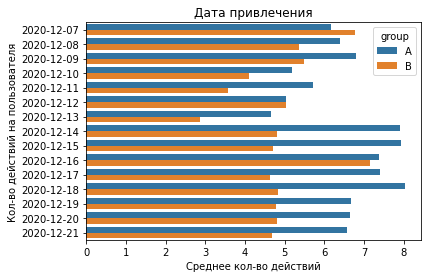

In [21]:
# группирую по дате привлечения и подгруппам
temp_1 = final_ab_events.groupby(['first_date', 'group'], as_index=False).agg({'user_id': 'nunique', 'event_name': 'count'})
temp_1.rename(columns={'user_id': 'n_users', 'event_name': 'n_events'}, inplace=True)
temp_1['mean_n_events'] = temp_1['n_events'] / temp_1['n_users'] 
temp_1['first_date'] = temp_1['first_date'].dt.date

# визуализирую
ax = sns.barplot(data=temp_1, x='mean_n_events', y='first_date', hue='group')
ax.set_title('Дата привлечения')
ax.set_xlabel('Среднее кол-во действий')
ax.set_ylabel('Кол-во действий на пользователя')

Среднее количество действий пользователей подгруппы A почти во всех случаях значительно больше, чем группы B. Это может быть обусловлено влиянием эксперимента. В целом распределение событий между пользователями по подгруппам и дням распределено достаточно равномерно.

## Выводы по корректности проведения теста

- Данные частично соответсвтуют требованиям ТЗ: начало и окончание сбора пользователей соответствует ТЗ, сбор событий завершился раньше запланированного на 5 дней раньше. Это должно одинаково повлиять на обе группы теста
- Время проведения теста совпадает с двумя маркетинговыми активностями, но, скорее всего, они воздействуют на пользователей обеих групп одинаково
- Часть аудитории теста участвовали в других экспериментах в группах B и были исключены
- Активность групп распределена неравномерно по времени

Исходя из приведенных выше замечаний, тест проведен некорректно и не стоит полагаться на его результаты без проведения дополнительного теста с исправлением замечаний.

# Исследовательский анализ данных

## Количество событий на пользователя одинаково распределены в выборках?

Text(0, 0.5, 'Кол-во действий на пользователя')

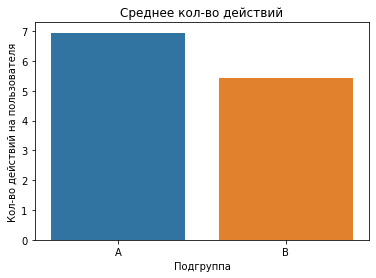

In [22]:
# группирую по подгруппам
temp_1 = final_ab_events.groupby('group', as_index=False).agg({'user_id': 'nunique', 'event_name': 'count'})
temp_1.rename(columns={'user_id': 'n_users', 'event_name': 'n_events'}, inplace=True)
temp_1['mean_n_events'] = temp_1['n_events'] / temp_1['n_users'] 

# визуализирую
ax = sns.barplot(data=temp_1, x='group', y='mean_n_events')
ax.set_title('Среднее кол-во действий')
ax.set_xlabel('Подгруппа')
ax.set_ylabel('Кол-во действий на пользователя')

Количество среднего количества действий на пользователя между группами отличается - пользователь из группы А совершает на 1-1,5 действий больше. Это может быть связано с влиянием нововведения

## Как число событий в выборках распределено по дням?

Text(0, 0.5, 'Дата привлечения')

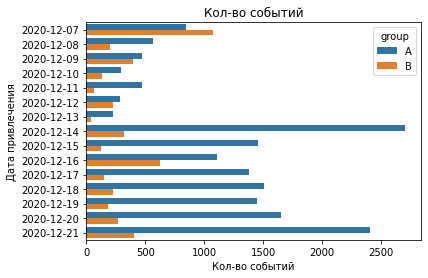

In [23]:
# группирую по дате привлечения и подгруппам
temp_1 = final_ab_events.groupby(['first_date', 'group'], as_index=False).agg({'user_id': 'nunique', 'event_name': 'count'})
temp_1.rename(columns={'user_id': 'n_users', 'event_name': 'n_events'}, inplace=True)
temp_1['first_date'] = temp_1['first_date'].dt.date

# визуализирую
ax = sns.barplot(data=temp_1, x='n_events', y='first_date', hue='group')
ax.set_title('Кол-во событий')
ax.set_xlabel('Кол-во событий')
ax.set_ylabel('Дата привлечения')

Абсолютное количество событий по дням распределено более-менее равномерно у группы B, и неравномерно у группы А: начиная с 14 декабря количество действий увеличилось почти в два раза. Маркетинговые активности в этот день не начинались.

Рост абсолютного числа событий может быть связан с ростом количества пользователей в эти дни. Исследуем

Text(0, 0.5, 'Дата привлечения')

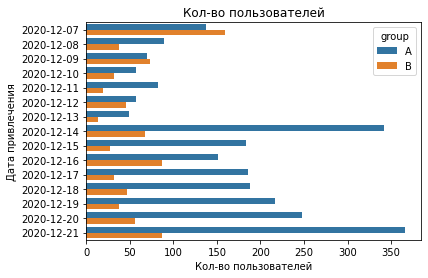

In [24]:
# визуализирую
ax = sns.barplot(data=temp_1, x='n_users', y='first_date', hue='group')
ax.set_title('Кол-во пользователей')
ax.set_xlabel('Кол-во пользователей')
ax.set_ylabel('Дата привлечения')

Действительно, рост активности в эти дни связан с темпом набора пользователей в тест.

## Как меняется конверсия в воронке в выборках на разных этапах?

In [25]:
# строю сводную таблицу для определения этапов вовронки
temp_1 = final_ab_events.groupby(['first_date', 'group', 'event_name'], as_index=False).agg({'event_dt': 'count'})
temp_1.rename(columns={'event_dt': 'n_iteractions'}, inplace=True)
temp_1.head()

,first_date,group,event_name,n_iteractions
0,2020-12-07,A,login,393
1,2020-12-07,A,product_cart,95
2,2020-12-07,A,product_page,248
3,2020-12-07,A,purchase,109
4,2020-12-07,B,login,472


Судя по распределению количества действий на разных этапах, воронка выглядит следующим образом: логин -> просмотр карточки товара -> покупка. Есть необязательное действие добавление товара в корзину: так как кол-во покупок больше чем добавлений в корзину, товар можно купить сразу с карточки. Так как действия с корзиной не являются предметом исследования данного теста и не являются обязательным шагом в воронке, то это событие можно исключить.

In [26]:
# исключаю необязательный шаг
final_ab_events_no_pc = final_ab_events.query('event_name != "product_cart"')

# собираю сводную таблицу для ответа на вопрос
temp_1 = final_ab_events_no_pc.groupby(['first_date', 'group', 'event_name'], as_index=False).agg({'event_dt': 'count'})
temp_1.rename(columns={'event_dt': 'n_iteractions'}, inplace=True)
temp_1['n_iteractions_shifted'] = temp_1.groupby(['first_date', 'group'], as_index=False)['n_iteractions'].shift(1)
temp_1['share'] = temp_1['n_iteractions'] / temp_1['n_iteractions_shifted'] *100
temp_1['first_date'] = temp_1['first_date'].dt.date
temp_1

,first_date,group,event_name,n_iteractions,n_iteractions_shifted,share
0,2020-12-07,A,login,393,NaN,NaN
1,2020-12-07,A,product_page,248,393.0,63.104326
2,2020-12-07,A,purchase,109,248.0,43.951613
3,2020-12-07,B,login,472,NaN,NaN
4,2020-12-07,B,product_page,300,472.0,63.559322
...,...,...,...,...,...,...
85,2020-12-21,A,product_page,700,1069.0,65.481759
86,2020-12-21,A,purchase,340,700.0,48.571429
87,2020-12-21,B,login,202,NaN,NaN
88,2020-12-21,B,product_page,108,202.0,53.465347


Text(0, 0.5, 'Дата привлечения')

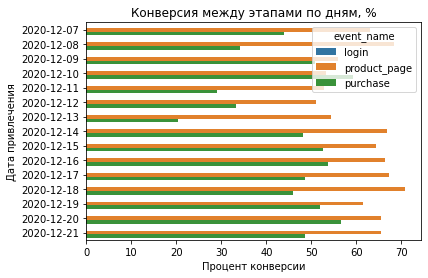

In [27]:
# визуализирую конверсию группы А
temp_a = temp_1.query('group == "A"')
ax = sns.barplot(data=temp_a, x='share', y='first_date', hue='event_name')
ax.set_title('Конверсия между этапами по дням, %')
ax.set_xlabel('Процент конверсии')
ax.set_ylabel('Дата привлечения')

В группе А во все дни процент конверсии из логинов в просмотр карточки товара составляет около 65-70%. Конверсия в покупки из просмотров карточек менее стабильная и составляет около 50% в среднем. Есть провалы 11-13 декабря.

Text(0, 0.5, 'Дата привлечения')

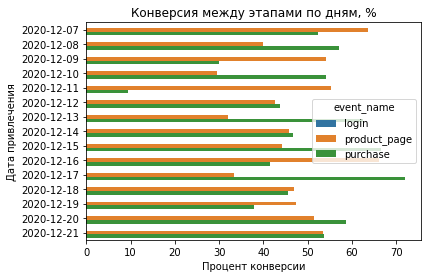

In [28]:
# визуализирую конверсию группы B
temp_b = temp_1.query('group == "B"')
ax = sns.barplot(data=temp_b, x='share', y='first_date', hue='event_name')
ax.set_title('Конверсия между этапами по дням, %')
ax.set_xlabel('Процент конверсии')
ax.set_ylabel('Дата привлечения')

В группе B конверсия из логинов в просмотры карточек снизилась до 40-50%, а конверсия в покупки относительно просмотров карточек осталась примерно такой же. Возможно, новая рекомендательная система привела к тому, что карточки товаров теперь открывают реже, а покупают из них - так же. Стоит посмотреть средние значения по группам без разбивки по дням.

In [29]:
# без разбивки по датам
temp_1 = final_ab_events_no_pc.groupby(['group', 'event_name'], as_index=False).agg({'event_dt': 'count'})
temp_1.rename(columns={'event_dt': 'n_iteractions'}, inplace=True)
temp_1['n_iteractions_shifted'] = temp_1.groupby(['group'], as_index=False)['n_iteractions'].shift(1)
temp_1['share'] = temp_1['n_iteractions'] / temp_1['n_iteractions_shifted'] *100
temp_1

,group,event_name,n_iteractions,n_iteractions_shifted,share
0,A,login,7450,NaN,NaN
1,A,product_page,4804,7450.0,64.483221
2,A,purchase,2319,4804.0,48.272273
3,B,login,2184,NaN,NaN
4,B,product_page,1148,2184.0,52.564103
5,B,purchase,547,1148.0,47.648084


Выводы подверждаются: снизилась конверсия логинов в просмотры товаров, уровень оплат из просмотра товаров остался тем же. Пока нельзя однозначно сказать, как повлияла рекомендательная система на работу магазина. Может быть, пользователям приходится меньше заходить в приложение, так как они быстрее находят нужный товар? Нужно посмотреть конверсию логин -> покупка и долю пользователей с покупками 

In [30]:
# конверсия логин-> покупка
temp_1 = final_ab_events_no_pc.query('event_name != "product_page"')
temp_1 = temp_1.groupby(['group', 'event_name'], as_index=False).agg({'event_dt': 'count'})
temp_1.rename(columns={'event_dt': 'n_iteractions'}, inplace=True)
temp_1['n_iteractions_shifted'] = temp_1.groupby(['group'], as_index=False)['n_iteractions'].shift(1)
temp_1['share'] = temp_1['n_iteractions'] / temp_1['n_iteractions_shifted'] *100
temp_1


,group,event_name,n_iteractions,n_iteractions_shifted,share
0,A,login,7450,NaN,NaN
1,A,purchase,2319,7450.0,31.127517
2,B,login,2184,NaN,NaN
3,B,purchase,547,2184.0,25.045788


Нет, конверсия логин -> покупка тоже снизилась.

In [31]:
# доля платящих пользователей в группах
print('Доля платящих пользователей A', len(final_ab_events.query('event_name == "purchase" and group == "A"')['user_id'].unique()) / len(recommender_system_test_participants.query('group == "A"')['user_id'].unique()))
print('Доля платящих пользователей B', len(final_ab_events.query('event_name == "purchase" and group == "B"')['user_id'].unique()) / len(recommender_system_test_participants.query('group == "B"')['user_id'].unique()))

Доля платящих пользователей A 0.3191577208918249
Доля платящих пользователей B 0.2749391727493917


Строю интерактивную воронку по группам

In [39]:
# без разбивки по датам
temp_1 = final_ab_events_no_pc.groupby(['group', 'event_name'], as_index=False).agg({'event_dt': 'count'})
temp_1.rename(columns={'event_dt': 'n_iteractions'}, inplace=True)
temp_1['n_iteractions_shifted'] = temp_1.groupby(['group'], as_index=False)['n_iteractions'].shift(1)
temp_1['share'] = temp_1['n_iteractions'] / temp_1['n_iteractions_shifted'] *100

fig = go.Figure()

fig.add_trace(go.Funnel(
    name = 'A',
    y = temp_1.query('group == "A"')['event_name'],
    x = temp_1.query('group == "A"')['n_iteractions'],
    textposition = "inside",
    textinfo = "value+percent previous"))

fig.add_trace(go.Funnel(
    name = 'B',
    orientation = "h",
    y =  temp_1.query('group == "B"')['event_name'],
    x = temp_1.query('group == "B"')['n_iteractions'],
    textposition = "inside",
    textinfo = "value+percent previous"))
fig.show()

In [33]:
# без разбивки по датам
temp_1 = final_ab_events.groupby(['group', 'event_name'], as_index=False).agg({'event_dt': 'count'})
temp_1.rename(columns={'event_dt': 'n_iteractions'}, inplace=True)
temp_1['n_iteractions_shifted'] = temp_1.groupby(['group'], as_index=False)['n_iteractions'].shift(1)
temp_1['share'] = temp_1['n_iteractions'] / temp_1['n_iteractions_shifted'] *100
temp_1 = temp_1.reindex([0, 2, 1, 3, 4, 6, 5, 7])
fig = go.Figure()

fig.add_trace(go.Funnel(
    name = 'A',
    y = temp_1.query('group == "A"')['event_name'],
    x = temp_1.query('group == "A"')['n_iteractions'],
    textposition = "inside",
    textinfo = "value+percent previous"))

fig.add_trace(go.Funnel(
    name = 'B',
    orientation = "h",
    y =  temp_1.query('group == "B"')['event_name'],
    x = temp_1.query('group == "B"')['n_iteractions'],
    textposition = "inside",
    textinfo = "value+percent previous"))

fig.update_layout(title='Воронка по этапам магазина')
fig.show()

Конверсия в просмотры товара снизилась почти на 10%, конверсия в покупки из предыдущего шага не изменилась.

## Какие особенности данных нужно учесть, прежде чем приступать к A/B-тестированию?

* Количество событий распределено неравномерно не только между группами, но и во времени
* Есть необязательный этап в воронке
* На данные могли влиять маркетинговые активности и другие факторы

## Выводы по EDA

- Количество событий на пользователя распределено не равномерно: пользователь из группы А совершает на 1-1,5 действий больше.
- Абсолютное кол-во событий по дням и группам распределено неравномерно: у группы B кол-во событий изменяется от 20-30 до 1200, у группы А с 7 декабря снижается с 1000 до 400, 14 декабря растет до 2500 и снова снижается до 1500.
- В группе B снизилась конверсия логинов в просмотры товаров, уровень оплат из просмотра товаров остался тем же. Конверсия активных пользователей в покупателей тоже снизилась.

# Оценка результататов A/B-тестирования

## Что можно сказать про результаты A/В-тестирования?

Данные теста соответствуют тербованиям ТЗ к аудитории. Однако в самом тесте среднее количество событий между группами и по дням распределено неравномерно, в одно время с исследованием проходят маргетинговые активности. Ожидаемый эффект не достигается, метрики не только не выросли на 10%, но и снизились. Я бы предположил, что тест проведен неудовлетворительно и для оценки влияния новой рекоммендательной системы его стоит провести еще раз.

## Проверьте статистическую разницу долей z-критерием.

нужно провести три теста о равенстве долей. Размеры выборок - кол-во активных (залогинившихся) пользователей в каждой группе, кол-во успехов - кол-во просмотров товара, корзины и оплаты для каждой группы

Для каждого теста рабочая гипотеза: доли в выборках равны, группы не отличаются по поведению
Основная гипотеза H0 - доли в выборках равны
Альтернативная гипотеза H1 - между долями есть значительная разница

Критический уровень значимости 0,05

In [34]:
# задаю критический уровень значимости с поправкой на множественное сравнение (3)
alpha = 0.05 / 3



In [35]:
# тест доли просмотров карточки товара

trials = np.array([
    len(recommender_system_test_participants.query('group == "A"')['user_id'].unique()),
    len(recommender_system_test_participants.query('group == "B"')['user_id'].unique())
])

successes = np.array([
    len(final_ab_events.query('event_name == "product_page" and group == "A"')['user_id'].unique()),
    len(final_ab_events.query('event_name == "product_page" and group == "B"')['user_id'].unique())
])

# доля в группе A
p1 = successes[0] / trials[0]

# доля в группе B
p2 = successes[1] / trials[1]



# Пропорция в комбинированном датасете
p_combined = (successes[0] + successes[1])/(trials[0] + trials[1])

# Разница пропорций в датасетах
difference = p1-p2

# расчет статистики в ст. отклонениях ст. норм. распределения
z_value = difference / mth.sqrt(p_combined*(1-p_combined)*(1/trials[0] + 1/trials[1]))

# задаем стандартное распределение
distr = st.norm(0, 1)

# Рассчитываю p-value
p_value = (1-distr.cdf(abs(z_value)))*2

print('p-значение: ', p_value)

if p_value < alpha:
    print('Отвергаем нулевую гипотезу, между долями есть значимая разница')
else:
    print('Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными')

print('Разница между долями a и b: ', difference*100)

p-значение:  3.8415005565450855e-06
Отвергаем нулевую гипотезу, между долями есть значимая разница
Разница между долями a и b:  9.024332909401044


Статистический тест свидетельствует о том, что доли в группах нельзя считать равными. Конверсия в просмотр карточек товаров на 9% выше у группы A!

In [36]:
# тест доли просмотров корзины

trials = np.array([
    len(recommender_system_test_participants.query('group == "A"')['user_id'].unique()),
    len(recommender_system_test_participants.query('group == "B"')['user_id'].unique())
])

successes = np.array([
    len(final_ab_events.query('event_name == "product_cart" and group == "A"')['user_id'].unique()),
    len(final_ab_events.query('event_name == "product_cart" and group == "B"')['user_id'].unique())
])

# доля в группе A
p1 = successes[0] / trials[0]

# доля в группе B
p2 = successes[1] / trials[1]

print(successes[0], successes[1], trials[0], trials[1])

# Пропорция в комбинированном датасете
p_combined = (successes[0] + successes[1])/(trials[0] + trials[1])

# Разница пропорций в датасетах
difference = p1-p2

# расчет статистики в ст. отклонениях ст. норм. распределения
z_value = difference / mth.sqrt(p_combined*(1-p_combined)*(1/trials[0] + 1/trials[1]))

# задаем стандартное распределение
distr = st.norm(0, 1)

# Рассчитываю p-value
p_value = (1-distr.cdf(abs(z_value)))*2

print('p-значение: ', p_value)

if p_value < alpha:
    print('Отвергаем нулевую гипотезу, между долями есть значимая разница')
else:
    print('Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными')

print('Разница между долями a и b: ', difference*100)

728 225 2422 822
p-значение:  0.14412076974264498
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
Разница между долями a и b:  2.6855406944854665


Статистический тест свидетельствует о том, что доли в группах нельзя считать равными. Конверсия в просмотр корзины на 2% выше у группы A!

In [37]:
# тест доли покупок

trials = np.array([
    len(recommender_system_test_participants.query('group == "A"')['user_id'].unique()),
    len(recommender_system_test_participants.query('group == "B"')['user_id'].unique())
])

successes = np.array([
    len(final_ab_events.query('event_name == "purchase" and group == "A"')['user_id'].unique()),
    len(final_ab_events.query('event_name == "purchase" and group == "B"')['user_id'].unique())
])

# доля в группе A
p1 = successes[0] / trials[0]

# доля в группе B
p2 = successes[1] / trials[1]

print(successes[0], successes[1], trials[0], trials[1])

# Пропорция в комбинированном датасете
p_combined = (successes[0] + successes[1])/(trials[0] + trials[1])

# Разница пропорций в датасетах
difference = p1-p2

# расчет статистики в ст. отклонениях ст. норм. распределения
z_value = difference / mth.sqrt(p_combined*(1-p_combined)*(1/trials[0] + 1/trials[1]))

# задаем стандартное распределение
distr = st.norm(0, 1)

# Рассчитываю p-value
p_value = (1-distr.cdf(abs(z_value)))*2

print('p-значение: ', p_value)

if p_value < alpha:
    print('Отвергаем нулевую гипотезу, между долями есть значимая разница')
else:
    print('Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными')

print('Разница между долями a и b: ', difference*100)

773 226 2422 822
p-значение:  0.01764968717521609
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
Разница между долями a и b:  4.42185481424332


Множественный статистический тест свидетельствует о том, что доли просмотров карточек в группах нельзя считать равными. Конверсия в просмотры карточки у группы B снизилась на 9%! Изменение конверсий в просмотр корзины и покупки статистически не значимо.

## Выводы по a/b тестам

Как и предполагалось на этапе EDA, доли по просмотрам карточек в группах не равны, и группа A показывает результаты лучше, чем B. Я считаю, что негативные результаты теста принимать нельзя из-за неравномерности распределения событий между группами и днями. Для подтверждения или опровержения гипотезы о новой рекомендательной системе нужно провести новое исследование

# Общие выводы

В результате работы над проектом:
1. Исходные данные теста проверены на соответствие техническому заданию. Основные требования соблюдены, но:
    * обнаружены пользователи, участвовавшие в других тестах
    * во время проведения теста проводились маркетинговые активности
    * обнаружено значительное расхождение в количестве средних действий на человека между подгруппами в пользу группы A
2. Проведен исследовательский анализ данных, который показал неравномерность распределения абсолютного количества действий между группами A и B, а также по дням (связано с неравномерным притоком пользователей в тест). Построены воронки для групп A и B. В группе B снизилась конверсия логинов в просмотры товаров, уровень оплат из просмотра товаров остался тем же. Конверсия активных пользователей в покупателей тоже снизилась.
3. Проверены гипотезы о равенстве или росте конверсий активных пользователей в просмотры товаров, корзины и покупки:
    * Конверсия в просмотр товаров в группе B снизилась на 9%, и это статистически значимо.
    * Изменение конверсий в просмотр корзины и покупки между группами статистически не значимо.
Эффект от внедрения рекомендательной системы оказался негативным.
4. К данным теста есть много вопросов, исследование по ним может привести к неправильным выводам.

Рекомендуется:
1. Отложить внедрение рекомендательной системы.
2. Провести тест заново с период, не пересекающийся с сезонными явлениями, праздниками и маркетинговыми активностями. Слеледить за схожестью участвующих пользователей.